In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mayavi import mlab
from tvtk.tools import visual
from scipy import interpolate
import math
from numpy import unravel_index
import pickle
from datalib import Data
from mayavi import mlab
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import healpy as hp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
datadir='.'
data=Data(datadir)
conf = data._conf
c = 3e10

def cal_PA(multipole, average, openfieldlines, aberration, T, h, r_em, view_angle):
   
    dir = 'Data/Multipole/'
    omega = 2*np.pi/T
    # calculate omega_p to be used in aberration. omega*1e3*1e6/c
    omega_p = omega*0.1/3.0
    c = 3e10
    ini_ph = 0.05*210%(2*np.pi)*180/np.pi
    minth = 0
    maxth = np.pi
    minphi = -np.pi
    maxphi = np.pi
    
    px = 0.0
    py = 0.985
    pz = 0.174
    

    def get_field(x0,y0,z0):
        t = 4.21*T/2/np.pi
        R = 2
        x = np.cos(omega*t)*x0+np.sin(omega*t)*y0
        y = -np.sin(omega*t)*x0+ np.cos(omega*t)*y0
        z = z0
        r1 = np.sqrt(x**2+y**2+z**2)
        r2 = np.sqrt(x**2+y**2+(z-0.4*R)**2)
        rqrt = 0.6*x**2 + y*(-0.8*y-2*(z-0.4*R)) + (z-0.4*R)*(-2*y+0.2*(z-0.4*R))
        #rqrt = 0.6*x**2 + y*(-0.8*y-2*(z+0.4*R)) + (z+0.4*R)*(-2*y+0.2*(z+0.4*R))
        bxd = R**3*(-px/r1**3 + 3*(px*x+py*y+pz*z)*x/r1**5)
        byd = R**3*(-py/r1**3 + 3*(px*x+py*y+pz*z)*y/r1**5)
        bzd = R**3*(-pz/r1**3 + 3*(px*x+py*y+pz*z)*z/r1**5)
        bxq = R**4*(-2*0.6*x/r2**5 + 5.0*(rqrt)*x/r2**7)
        byq = R**4*(-2*(-0.8*y-2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*y/r2**7)
        bzq = R**4*(-2*(-2*y+0.2*(z-0.4*R))/r2**5 + 5.0*(rqrt)*(z-0.4*R)/r2**7)
        if multipole:
            bx = bxd+bxq
            by = byd+byq
            bz = bzd+bzq
        else:
            bx = bxd
            by = byd
            bz = bzd     
        Bx = np.cos(omega*t)*bx - np.sin(omega*t)*by
        By = np.sin(omega*t)*bx + np.cos(omega*t)*by
        Bz = bz
        Bmag = np.sqrt(Bx**2+By**2+Bz**2)
        return Bx/Bmag, By/Bmag, Bz/Bmag


    
    def rescale_phi(phi):
        n_id = np.where(phi<0)[0]
        phi[n_id] = phi[n_id]+2*np.pi
        return phi

        
    def get_k(bx,by,bz,p1,p2,p3):
        kfac1 = -omega_p*(-p2*bx+p1*by) + np.sqrt(omega_p**2*(-p2*bx+p1*by)**2-omega_p**2*(p1**2+p2**2)+1)
        kfac2 = -omega_p*(-p2*bx+p1*by) - np.sqrt(omega_p**2*(-p2*bx+p1*by)**2-omega_p**2*(p1**2+p2**2)+1)
        return kfac1,kfac2
    
    
    # calculate field components at the emission radius
    
    if openfieldlines:
        p1 = xpo2
        p2 = ypo2
        p3 = zpo2 
        r_em = np.sqrt(xpo2[0]**2+ypo2[0]**2+zpo2[0]**2)
        
    else:
        #n1=200
        #n2=200
        th,ph = np.mgrid[minth:maxth:400j, minphi:maxphi:400j]
        xsurf = r_em*np.sin(th)*np.cos(ph)
        ysurf = r_em*np.sin(th)*np.sin(ph)
        zsurf = r_em*np.cos(th)
        p1 = xsurf.flatten()
        p2 = ysurf.flatten()
        p3 = zsurf.flatten()
    
    #coords=np.stack((p3,p2,p1),axis=-1)
    #Bxf,Byf,Bzf = field_func(data_bx,data_by,data_bz)
    #bz = (Bzf(coords))
    #by = (Byf(coords))
    #bx = (Bxf(coords))

    bx,by,bz = get_field(p1,p2,p3)
    
    
    #transform into spherical
    
    thetas = np.arccos(p3/r_em)
    phis = np.arctan2(p2,p1)
        
    if aberration:
        
        kfac1,kfac2 = get_k(bx,by,bz,p1,p2,p3)

        v1,v2,v3,kfac = [],[],[],[]
        for i in range(len((kfac1))):
            va1 = -omega_p*p2[i]+kfac1[i]*bx[i]
            vb1 = omega_p*p1[i]+kfac1[i]*by[i]
            vc1 = kfac1[i]*bz[i]   
            va2 = -omega_p*p2[i]+kfac2[i]*bx[i]
            vb2 = omega_p*p1[i]+kfac2[i]*by[i]
            vc2 = kfac2[i]*bz[i] 
            vr1 = np.sin(thetas[i])*np.cos(phis[i])*va1 + np.sin(thetas[i])*np.sin(phis[i])*vb1 + np.cos(thetas[i])*vc1
            vr2 = np.sin(thetas[i])*np.cos(phis[i])*va2 + np.sin(thetas[i])*np.sin(phis[i])*vb2 + np.cos(thetas[i])*vc2
            if (vr1>=0):
                v1.append(va1)
                v2.append(vb1)
                v3.append(vc1)
                kfac.append(kfac1[i])
            elif (vr2>=0):
                v1.append(va2)
                v2.append(vb2)
                v3.append(vc2)
                kfac.append(kfac2[i])
            else:
                print ("problem")

                  
    else:

        br = np.sin(thetas)*np.cos(phis)*bx + np.sin(thetas)*np.sin(phis)*by + np.cos(thetas)*bz
        bth = np.cos(thetas)*np.cos(phis)*bx + np.cos(thetas)*np.sin(phis)*by - np.sin(thetas)*bz
        bphi = -np.sin(phis)*bx + np.cos(thetas)*by
        
        ids_in = np.where(br<=0.0)[0]
        ids_out = np.where(br>0)[0]
        
        bz[ids_in] = -bz[ids_in]
        by[ids_in] = -by[ids_in]
        bx[ids_in] = -bx[ids_in]
        
        v1 = bx
        v2 = by
        v3 = bz
        
        
    ex = np.array(v1)
    ey = np.array(v2)
    ez = np.array(v3)
    #kfac = np.array(kfac)
    
    th_obs = np.arccos(ez)
    
    phi0 = -np.arctan2(ey,ex)
    dphi = -((p1*ex + p2*ey + p3*ez)*1e9*omega/c)
    phi_obs = (phi0+dphi)
    
        
    #rotate to make the observer on the x-z plane
    ex1 = ex*np.cos(phi0)-np.sin(phi0)*ey
    ey1 = ex*np.sin(phi0)+np.cos(phi0)*ey
    ez1 = ez
    
    #rotate to make the observer along the z-axis
    deltas = np.arctan(ex1/ez1)
    
    #rotation about y-axis
    Ex = np.cos(deltas)*ex1 - np.sin(deltas)*ez1
    Ey = ey1
    Ez = np.sin(deltas)*ex1 + np.cos(deltas)*ez1
    
    ##### after this step, Ex and Ey are zero
    
    #calculate the point after the ray propagates
    xsurf_2 = p1+(h*np.sin(th_obs)*np.cos(-phi0))
    ysurf_2 = p2+(h*np.sin(th_obs)*np.sin(-phi0))
    zsurf_2 = p3+(h*np.cos(th_obs))

    ##############
    #rotate the star
    
    #first inverse transform the coordinates
    
    phi_ray = h*1e9/c*omega
    xsurf_p = xsurf_2*np.cos(phi_ray)+np.sin(phi_ray)*ysurf_2
    ysurf_p = -xsurf_2*np.sin(phi_ray)+np.cos(phi_ray)*ysurf_2
    zsurf_p = zsurf_2

    #coords_p = np.stack((zsurf_p,ysurf_p,xsurf_p),axis=-1)

    #calculate field
    
    #bzp = (Bzf(coords_p))
    #byp = (Byf(coords_p))
    #bxp = (Bxf(coords_p))
    bxp,byp,bzp = get_field(xsurf_p,ysurf_p,zsurf_p)
    
    
    #calculate the omega x r term
    
    beta_x = -ysurf_p*2*np.pi*1e9/T/c
    beta_y = xsurf_p*2*np.pi*1e9/T/c
    beta_z = 0
        
    beta1 = beta_x*np.cos(phi_ray)-np.sin(phi_ray)*beta_y
    beta2 = beta_x*np.sin(phi_ray)+np.cos(phi_ray)*beta_y
    beta3 = beta_z
        
            
    ## rotate the star because initial field is fixed
    b1 = bxp*np.cos(phi_ray)-np.sin(phi_ray)*byp
    b2 = bxp*np.sin(phi_ray)+np.cos(phi_ray)*byp
    b3 = bzp
    
    # apply same transformations as before
    
    #rotation 1 (check phi0 rotation)
    
    bx1p = b1*np.cos(phi0)-np.sin(phi0)*b2
    by1p = b1*np.sin(phi0)+np.cos(phi0)*b2
    bz1p = b3
    
    # rotation 2 (check deltas rotation)
    
    Bx = np.cos(deltas)*bx1p - np.sin(deltas)*bz1p
    By = by1p
    Bz = np.sin(deltas)*bx1p + np.cos(deltas)*bz1p
    
    if aberration:
    
        beta_1 = beta1*np.cos(phi0)-np.sin(phi0)*beta2
        beta_2 = beta1*np.sin(phi0)+np.cos(phi0)*beta2
        beta_3 = beta3
    
        Betax = np.cos(deltas)*beta_1 - np.sin(deltas)*beta_3
        Betay = beta_2
        Betaz = np.sin(deltas)*beta_1 + np.cos(deltas)*beta_3
    
        Ex = Bx+Bz*Betax-Bx*Betaz
        Ey = By+Bz*Betay-By*Betaz
                
    else:
        Ex = Bx
        Ey = By
        
    PA = np.arctan(Ey/Ex)
        
    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3

    ind = np.where(np.logical_and(th_obs>=0.0,th_obs<=180*np.pi/180))[0]
    inx = np.where(np.logical_and(phi_obs>=-180*np.pi/180,phi_obs<=180*np.pi/180))[0]
    intsc = (intersection(ind, inx))
    
    N = int(200)
    grid_th,grid_phi = np.mgrid[0:np.pi:200j, -np.pi:np.pi:200j]

    if average:
        
        
        PA_grid = np.zeros((N,N))
        count_grid = np.zeros((N,N))

        for i in range(len(th_obs)):
            curr_th = th_obs[i]
            curr_phi = phi_obs[i]
            index1 = round(curr_th*(N-1)/np.pi)
            #index2 = int(N/2.0)-1 + round(curr_phi*int(N/2.0)/np.pi)
            index2 = int((N-1)*(np.pi+curr_phi)/2/np.pi)
            PA_grid[index1][index2] += PA[i] 
            count_grid[index1][index2]+=1
    
    
        for i in range(N):
            for j in range(N):
                if count_grid[i][j]!=0:
                    PA_grid[i][j] = PA_grid[i][j]/count_grid[i][j] 
                
           
        PA_grid[PA_grid==0] = np.nan
    

    else:
        PA_grid = griddata((th_obs,phi_obs), PA, (grid_th, grid_phi), method='linear')
        
    
   
    all_thetas = np.linspace(0,np.pi,N)
    point1 = np.where(all_thetas*180/np.pi<view_angle)
    point1 = (point1[0][-1])
    angle1 = np.round(all_thetas[point1]*180/np.pi)
    
    view = np.round(80-angle1,2)
    print ("multipole = ", multipole)
    print ("aberration = ", aberration)
    print ("openfieldlines = ", openfieldlines)
    print ("Light cylinder="+str(np.ceil(c/omega/1e3/1e6))+"R")
    print ("impact angle = "+str(view)+" degrees")
    print ("viewing angle = "+str(angle1)+" degrees")
    print ("emission height = "+str(h)+" R")
    print ("emission radius = "+str(round(r_em))+" R")

    plt.figure(figsize=(6,5))
    plt.contourf(grid_phi*180/np.pi,grid_th*180/np.pi,PA_grid,cmap='bwr')
    plt.xlim(-180,180)
    plt.ylim(0,180)
    plt.axhline(y=angle1, color='k', linestyle='-')
    plt.colorbar(label="PA")    
    plt.xlabel(r'$\rm \phi_{obs}$ [deg]',size=20)
    plt.ylabel(r'$\rm \theta_{obs}$ [deg]',size=20)
    plt.savefig(dir+'PAgrid_openf_avg_rem_15_h1.png')
    plt.show()
    plt.close()

    if average:
        xval = np.linspace(-np.pi,np.pi,N)
        yval = PA_grid[point1]
        store_y, store_x = [],[]
        for i in range(len(yval)):
            if np.isnan(yval[i]):
                continue
            else:
                store_y.append(yval[i])
                store_x.append(xval[i])
        store_y = np.array(store_y)
        store_x = np.array(store_x)
        f = interpolate.interp1d(store_x,store_y)
        xar = np.linspace(min(store_x),max(store_x),200)
    
    
    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth


    
    plot = True
    a1 = np.linspace(-np.pi*180/np.pi,np.pi*180/np.pi,N)
    a2 = PA_grid[point1]*180/np.pi
    if plot:
        #a1 = rescale_phi(a1/180*np.pi)*180/np.pi
        plt.figure(figsize=(8,6))
        plt.scatter(a1,a2,c='k',s=3,label="Aberration=%s"%(aberration))
        plt.plot(a1,smooth(a2,8), 'b-', lw=1.5)
        #plt.plot(np.linspace(-np.pi*180/np.pi,np.pi*180/np.pi,N),PA_grid[point1]*180/np.pi,c='b',label="with aberration")
        plt.title("view="+str(angle1)+ " deg, em_height =" +str(height)+" R,  em radius="+str(np.round(r_em))+str("R"))
        #plt.text(250, -70, "em radius="+str(np.round(r_em))+str("R"), fontsize=15,c='b')
        plt.xlabel(r'$\rm \phi_{obs}$ [deg]',size=20)
        plt.ylabel(r'$\rm PA$ [deg]',size=20)
        plt.legend(loc='lower right')
        #plt.savefig('PA_curve_RT_openf3rem.png')
        plt.show()
        
    
    #return grid_th, grid_phi, PA_grid, th_obs[intsc], phi_obs[intsc], p1[intsc], p2[intsc], p3[intsc]
    return a1,a2

multipole =  False
aberration =  True
openfieldlines =  False
Light cylinder=20.0R
impact angle = 26.0 degrees
viewing angle = 54.0 degrees
emission height = 0.1 R
emission radius = 6 R


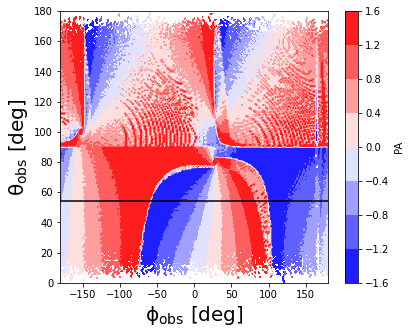

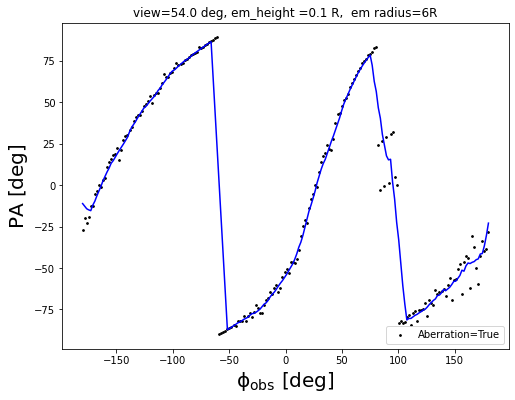

In [3]:
multipole = False
average = True
openfieldlines = False
aberration = True
T = 4.188
height = 0.1 ## in units of [R]
r_em = 6  ## in units of [R]
view_angle = 54.5 # in units of [deg]
 
a1,a2 = cal_PA(multipole, average, openfieldlines, aberration, T, height, r_em, view_angle)

In [64]:
dir = 'Data/Multipole/'
np.savetxt(dir+"PA_rem15_h1_view54_abr_mult.txt",np.c_[a1,a2])